In [1]:
import sys
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
import copy

from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
import networkx as nx

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

In [2]:
lrd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
monomers_fn = "/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa"

lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [3]:
# r_id1, r_id2 = "35aded7d-a60e-4628-ab38-4fd91010c0f6", "35aded7d-a60e-4628-ab38-4fd91010c0f6"

r_id1, r_id2 = "71fc9912-72f2-4f3e-95a0-a0311ebd0387", "35aded7d-a60e-4628-ab38-4fd91010c0f6"


#r_id1, r_id2 = "e1e9d70e-c20b-47fe-89b3-8777b85ccc43", "35aded7d-a60e-4628-ab38-4fd91010c0f6"

#r_id1, r_id2 = "71fc9912-72f2-4f3e-95a0-a0311ebd0387", "8f6d8463-6933-425a-8027-e0e8164026c0"
# r_id1, r_id2 = "0c50866b-f780-4551-a4bb-aa35a72f3f4d", "4578e1fd-b534-433e-87af-9e88fbdf48c1"

# r_id1, r_id2 = "aff6bdf9-4388-46e6-9aa5-af5c6c88258d", "c5bb3e14-3a0b-41f2-9b0f-2007cd12591f"


s1, s2 = lrd_report.records[r_id1].string, lrd_report.records[r_id2].string

In [4]:
def get_rare_mono_kmers(lrd_report, k, min_mult=5, max_mult=15):
    all_kmers = Counter()
    kmer_locations = defaultdict(list)
    for r_id, record in lrd_report.records.items():
        string = record.string
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                all_kmers[kmer] += 1
                kmer_locations[kmer].append((r_id, i))
                
    rare_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                  if min_mult <= cnt <= max_mult}
    reads2rare_kmers = defaultdict(list)
    for kmer in rare_kmers:
        locs = kmer_locations[kmer]
        for loc in locs:
            r_id, coordinate = loc
            reads2rare_kmers[r_id].append(coordinate)
    for r_id in reads2rare_kmers:
        reads2rare_kmers[r_id].sort()
    return rare_kmers, reads2rare_kmers


In [5]:
rare_kmers, reads2rare_kmers = get_rare_mono_kmers(lrd_report, k=200)

In [6]:
def compute_overlap(s1, s2, kmer_coords1, kmer_coords2, k=200):
    kmers2pos1 = {s1[i:i+k]: i for i in kmer_coords1}
    kmers2pos2 = {s2[i:i+k]: i for i in kmer_coords2}
    #print(kmers2pos1)
    
    kmers_inters = set(kmers2pos1.keys()) & set(kmers2pos2.keys())
    
    kmers2pos1 = {kmer: kmers2pos1[kmer] for kmer in kmers_inters}
    kmers2pos2 = {kmer: kmers2pos2[kmer] for kmer in kmers_inters}
    
    kmers2pos1 = sorted(kmers2pos1.items(), key=operator.itemgetter(1))
    kmers2pos2 = [(kmer, kmers2pos2[kmer]) for kmer, pos in kmers2pos1]
    
    pos1 = [x[1] for x in kmers2pos1]
    pos2 = [x[1] for x in kmers2pos2]
    discordancy = [0, 0]
    for p11, p12, p21, p22 in zip(pos1[:-1], pos1[1:],
                                  pos2[:-1], pos2[1:]):
        d1 = p12 - p11
        d2 = p22 - p21
        #print(p11, p21, d1, d2)
        if d1 != d2:
            discordancy[0] += 1
            discordancy[1] += d2 - d1
    
    fkmer_p1 = pos1[0] if len(pos1) else None
    fkmer_p2 = pos2[0] if len(pos2) else None
    return len(kmers_inters), discordancy, fkmer_p1, fkmer_p2
    # print([p[1] for p in kmers2pos1])
    # print([p[1] for p in kmers2pos2])
    
    # overlap = True
    # for kmer1 in kmers_inters:
    #     for kmer2 in kmers_inters:
    #         if kmer1 >= kmer2:
    #             continue
    #         d1 = kmers2pos1[kmer1] - kmers2pos1[kmer2]
    #         d2 = kmers2pos2[kmer1] - kmers2pos2[kmer2]
    #         print(d1, d2)
    #         if d1 != d2:
    #             overlap = False
                #break
        #if overlap is False:
        #    break
    
    # return (overlap, len(kmers_inters))

In [7]:
r_id1 = "4578e1fd-b534-433e-87af-9e88fbdf48c1"
r_id2 = "ee68ff9e-5a90-48bd-b8bf-b4a3e2e546a1"

r_id1 = "aff6bdf9-4388-46e6-9aa5-af5c6c88258d"
r_id2 = "ea6a949b-b0c9-4694-9fb5-cae9e9f915de"

r_id1 = "05c5a912-42ad-4a57-ae81-0a318dc8c6b7"
r_id2 = "0c849de1-fbde-4ff4-bf9e-a7675a011e11"

r_id1 = "ad5bb35b-1514-4dc9-a6c5-625233092167"
r_id2 = "64b137f0-6d19-47ba-8c2e-5043aedaf494"
compute_overlap(s1=lrd_report.records[r_id1].string,
                s2=lrd_report.records[r_id2].string,
                kmer_coords1=reads2rare_kmers[r_id1],
                kmer_coords2=reads2rare_kmers[r_id2])
                

(335, [0, 0], 303, 108)

In [8]:
def get_overlaps(lrd_report, reads2rare_kmers,
                 min_overlap_kmers=10,
                 max_discordant_pos=0,
                 min_ident=0.99,
                 min_overlap_len=300):
    overlaps = defaultdict(lambda: defaultdict(list))
    for r_id1 in lrd_report.records:
        overlaps[r_id1]
        for r_id2 in lrd_report.records:
            if r_id1 >= r_id2:
                continue
            s1 = lrd_report.records[r_id1].string
            s2 = lrd_report.records[r_id2].string
            overlap = compute_overlap(s1=s1, s2=s2,
                                      kmer_coords1=reads2rare_kmers[r_id1],
                                      kmer_coords2=reads2rare_kmers[r_id2])
            overlap_len, discordancy, fkmer_p1, fkmer_p2 = overlap
            if overlap_len >= min_overlap_kmers and discordancy[0] <= max_discordant_pos:
                shift = fkmer_p1 - fkmer_p2
                if shift >= 0:
                    hd = hamming_distance(s1[shift:], s2, match_char='=')
                    ident = 1 - hd[0] / hd[1]
                    if ident >= min_ident and hd[1] >= min_overlap_len:
                        # print(overlap, hd, ident)
                        overlaps[r_id1][r_id2] = (overlap_len, ident, hd[1], shift)
                else:
                    shift=-shift
                    hd = hamming_distance(s2[shift:], s1, match_char='=')
                    ident = 1 - hd[0] / hd[1]
                    if ident >= min_ident and hd[1] >= min_overlap_len:
                        # print(overlap, hd, ident)
                        overlaps[r_id2][r_id1] = (overlap_len, ident, hd[1], shift)
    return overlaps

In [9]:
overlaps = get_overlaps(lrd_report, reads2rare_kmers, min_overlap_kmers=10, min_ident=0.99, min_overlap_len=200)

In [10]:
for r_id1 in overlaps:
    for r_id2 in overlaps[r_id1]:
        overlap = overlaps[r_id1][r_id2]
        if overlap[0] > 0:
            print(r_id1, r_id2, overlap)

00739941-c14c-40bd-9fad-fabff753795b 5da9ab31-d608-4581-b5fd-37acce77300e (24, 1.0, 471, 327)
00739941-c14c-40bd-9fad-fabff753795b 8f633f5b-eb70-4ab0-94d2-77c708561492 (233, 1.0, 679, 59)
00739941-c14c-40bd-9fad-fabff753795b df436222-50d1-4975-861e-58ab06750067 (151, 1.0, 598, 200)
00739941-c14c-40bd-9fad-fabff753795b df9e6b8f-e94b-4bac-a69e-9e98b1769c42 (193, 1.0, 641, 157)
00739941-c14c-40bd-9fad-fabff753795b ea920754-ed98-43fc-aab4-10bc923ba16e (10, 1.0, 457, 341)
31700b15-5b3d-4d8c-b047-7836cb183613 00739941-c14c-40bd-9fad-fabff753795b (39, 1.0, 798, 19)
31700b15-5b3d-4d8c-b047-7836cb183613 5da9ab31-d608-4581-b5fd-37acce77300e (20, 1.0, 613, 346)
31700b15-5b3d-4d8c-b047-7836cb183613 8f633f5b-eb70-4ab0-94d2-77c708561492 (39, 1.0, 679, 78)
31700b15-5b3d-4d8c-b047-7836cb183613 df436222-50d1-4975-861e-58ab06750067 (39, 1.0, 676, 219)
31700b15-5b3d-4d8c-b047-7836cb183613 df9e6b8f-e94b-4bac-a69e-9e98b1769c42 (39, 1.0, 783, 176)
35e23dc0-4219-4951-b491-be041f325bf3 00739941-c14c-40bd-9fad

80e43596-26bd-4086-bb44-20f57549d706 d18b3668-7973-495b-80b9-69d390d24484 (43, 1.0, 418, 333)
80e43596-26bd-4086-bb44-20f57549d706 d67fce41-f360-4513-a994-e8ef3970b2cd (43, 1.0, 536, 215)
80e43596-26bd-4086-bb44-20f57549d706 dce9ae9a-d056-400b-939f-e005468e6f3d (43, 1.0, 580, 171)
ad5bb35b-1514-4dc9-a6c5-625233092167 057047e6-eb15-4d39-b4f6-473ecba0558a (57, 1.0, 625, 672)
ad5bb35b-1514-4dc9-a6c5-625233092167 267678a8-d2b5-49ec-a1b4-a5d0cca76626 (87, 1.0, 623, 706)
ad5bb35b-1514-4dc9-a6c5-625233092167 4baab0ec-f951-4fdd-8b47-ecc7f3fef697 (314, 1.0, 806, 889)
ad5bb35b-1514-4dc9-a6c5-625233092167 52c8f175-492a-4595-b644-a92a5851120c (46, 1.0, 906, 121)
ad5bb35b-1514-4dc9-a6c5-625233092167 5ff1565e-becf-48f1-a892-ad91e232bd5e (245, 1.0, 821, 1110)
ad5bb35b-1514-4dc9-a6c5-625233092167 6477d4cb-74ae-4152-95fb-717a34e6dd64 (528, 1.0, 1166, 641)
ad5bb35b-1514-4dc9-a6c5-625233092167 64b137f0-6d19-47ba-8c2e-5043aedaf494 (335, 1.0, 1356, 195)
ad5bb35b-1514-4dc9-a6c5-625233092167 7351ffd3-b56a-4c

ee709491-ebdf-4e40-b4ab-4f79c3f39ec2 182f1138-55b1-45dc-8230-e052f3aa6a44 (148, 1.0, 376, 309)
ee709491-ebdf-4e40-b4ab-4f79c3f39ec2 74058d14-e46a-401a-9125-e5941971408f (116, 1.0, 519, 166)
ee709491-ebdf-4e40-b4ab-4f79c3f39ec2 88736f6e-176d-4f3e-b044-8c9f5003ac56 (214, 1.0, 444, 241)
ee709491-ebdf-4e40-b4ab-4f79c3f39ec2 faaa25a5-d105-4e2f-80c0-c79c0f3bea3d (174, 1.0, 533, 152)
faaa25a5-d105-4e2f-80c0-c79c0f3bea3d 182f1138-55b1-45dc-8230-e052f3aa6a44 (69, 1.0, 497, 157)
faaa25a5-d105-4e2f-80c0-c79c0f3bea3d 74058d14-e46a-401a-9125-e5941971408f (48, 1.0, 640, 14)
faaa25a5-d105-4e2f-80c0-c79c0f3bea3d 88736f6e-176d-4f3e-b044-8c9f5003ac56 (135, 1.0, 565, 89)
faaa25a5-d105-4e2f-80c0-c79c0f3bea3d 92d8c15f-7fea-4944-bf7f-397e0ac6ae05 (10, 1.0, 225, 429)
faaa25a5-d105-4e2f-80c0-c79c0f3bea3d b3aab0e7-56f4-4d81-a151-c54dcd1a1500 (30, 1.0, 241, 413)
faaa25a5-d105-4e2f-80c0-c79c0f3bea3d d4447330-d508-4941-89a0-b491c5ad046e (30, 1.0, 255, 399)
345287e0-b556-4a73-b28d-961c95fa7747 19bbd83f-a594-4d19-8

In [11]:
class OverlapGraph:
    def __init__(self, overlaps):
        self.graph = nx.DiGraph()
        for r_id1 in overlaps:
            for r_id2 in overlaps[r_id1]:
                kmer_overlap, ident, overlap_len, shift = overlaps[r_id1][r_id2]
                self.graph.add_edge(r_id1, r_id2, weight=overlap_len, shift=shift)

In [12]:
graph = OverlapGraph(overlaps)

In [13]:
nx.number_weakly_connected_components(graph.graph)

2

In [14]:
    for cc in nx.weakly_connected_components(graph.graph):
        print(len(cc), nx.is_directed_acyclic_graph(graph.graph.subgraph(cc)))

251 True
82 True


In [15]:
nx.is_directed_acyclic_graph(graph.graph)

True

In [16]:
# nx.draw(graph.graph, pos=nx.spring_layout(graph.graph))

In [17]:
# nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(graph.graph)

# nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
#                              password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

In [18]:
def get_starting_reads(graph):
    starting_reads = [r_id for r_id, cnt in graph.graph.in_degree() if cnt == 0]
    return starting_reads

def get_ending_reads(graph):
    ending_reads = [r_id for r_id, cnt in graph.graph.out_degree() if cnt == 0]
    return ending_reads


# DP on the overlap graph

In [19]:
class MonomerContig:
    def __init__(self):
        self.max_pos = 0
        self.monomers = defaultdict(Counter)
        self.read_positions = {}
        self.coverage = defaultdict(int)
        self.string = ''

    def update_max_pos(self):
        if len(self.monomers):
            self.max_pos = max(self.monomers.keys())
        else:
            self.max_pos = 0
    
    def update_string(self):
        new_string = [0] * (self.max_pos + 1)
        for i, monomer_distr in self.monomers.items():
            new_string[i] = max(monomer_distr.items(),
                                key=operator.itemgetter(1))[0]
        self.string = ''.join(new_string)

    def add_read(self, r_id, monomer_string, position):
        self.read_positions[r_id] = position
        new_freq_kmers = []
        for i, monomer in enumerate(monomer_string):
            # print(self.monomers[i+position][monomer])
            self.coverage[i + position] += 1
            self.monomers[i + position][monomer] += 1
            # print(self.monomers[i+position][monomer])
            
        self.update_max_pos()
        self.update_string()
        # assert len(set(new_freq_kmers)) == len(new_freq_kmers)

    def get_score(self, monomer_string, position):
        upper_lim = min(self.max_pos + 1, position + len(monomer_string))
        pos_scores = []
        for i in range(position, upper_lim):
            monomer = monomer_string[i-position]
            cloud_monomers = self.monomers[i]
            pos_score = cloud_monomers[monomer] / sum(cloud_monomers.values())
            pos_scores.append(pos_score)
        score = sum(pos_scores)# / len(pos_scores)
        return score

In [20]:
def get_heaviest_path(graph, lrd_report):
    gr = graph.graph
    assert nx.is_directed_acyclic_graph(gr)
    
    weights = defaultdict(MonomerContig)
    for v in nx.topological_sort(gr):
        monomer_string = lrd_report.records[v].string
        if len(gr.in_edges(v)) == 0:
            weights[v].add_read(r_id=v, monomer_string=monomer_string, position=0)
        else:
            best_score, best_contig, best_pos = 0, None, None
            for edge in gr.in_edges(v):
                assert edge[1] == v
                u = edge[0]
                contig = weights[u]
                pos = contig.read_positions[u] + gr.edges[edge]['shift']
                score = contig.get_score(monomer_string=monomer_string, position=pos)
                if score > best_score:
                    best_score = score
                    best_contig = contig
                    best_pos = pos
            weights[v] = copy.deepcopy(best_contig)
            weights[v].add_read(v, monomer_string, position=best_pos)
    return weights

In [21]:
weights = get_heaviest_path(graph, lrd_report)

In [22]:
len(weights['1d0706f6-cc39-4a05-a4fd-2ee7e1674457'].monomers)

3408

In [23]:
def get_longest_contig(weights, graph):
    best_r_id = []
    for cc in nx.weakly_connected_components(graph.graph):
        cc_best_r_id, cc_best_len = None, 0 
        for r_id in cc:
            contig = weights[r_id]
            if len(contig.read_positions) > cc_best_len:
                cc_best_r_id = r_id
                cc_best_len = len(contig.read_positions)
        best_r_id.append(cc_best_r_id)
    return best_r_id

In [24]:
get_longest_contig(weights, graph)

['0c0dd3f7-6828-447b-ac53-1d118b0270a0',
 '2de12301-635c-4a93-a772-42e39317276b']

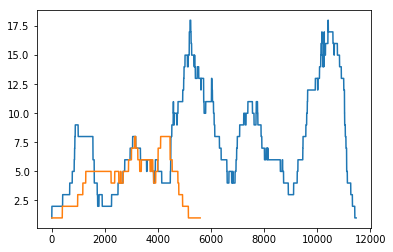

In [25]:
for r_id in get_longest_contig(weights, graph):
    longest_contig_cov = weights[r_id].coverage
    plt.plot(longest_contig_cov.keys(), longest_contig_cov.values())

In [26]:
# for i, monomer in weights[get_longest_contig(weights)].monomers.items():
#    print(i, monomer)

In [27]:
# weights[get_longest_contig(weights)].read_positions